In [55]:
# Importing Required Libraries
import cv2 
import numpy as np
import tensorflow 
import keras 
import matplotlib.pyplot as plt 
import keras_tuner as kt
from tensorflow.keras.models import load_model
from keras.layers import Activation

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adamax
from tensorflow.keras import regularizers
from keras.models import Model,Sequential 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, Conv2D, MaxPooling2D
from keras.applications import ResNet50, VGG16,VGG19, MobileNet
from keras.applications.efficientnet import EfficientNetB0, EfficientNetB3
from keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger,TensorBoard, ReduceLROnPlateau

In [3]:
# Generators
train = ImageDataGenerator(rotation_range=90,horizontal_flip = True, vertical_flip =True, rescale = 1./255, shear_range = 0.2,
                                   zoom_range = 0.2)
valid = ImageDataGenerator(rescale = 1./255)

test = ImageDataGenerator(rescale = 1./255)

In [4]:
training = train.flow_from_directory(r'/kaggle/input/cards-image-datasetclassification/train', target_size = (224,224),class_mode = 'sparse',batch_size=32)
validation = valid.flow_from_directory(r'/kaggle/input/cards-image-datasetclassification/valid',target_size = (224,224),class_mode = 'sparse',batch_size = 32)
testing = test.flow_from_directory(r'/kaggle/input/cards-image-datasetclassification/test', target_size = (224,224),class_mode = 'sparse',batch_size=32)

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## VGG19 Architecture

In [6]:
# CNN Architecture 
vgg = VGG19(include_top=False,
    weights='imagenet',input_shape=(224,224,3))

vgg.trainable=False

for i in vgg.layers:
    if i.name.startswith('block1_'):
        i.trainable=False
    else:
        i.trainable=True
for i in vgg.layers:
    print(i.name, i.trainable)

input_2 True
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_conv4 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_conv4 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [7]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Keras tuner with VGG19 

In [8]:
def build_model(hp):
    model = Sequential()
    
    model.add(vgg)
    model.add(Flatten())

    # Tune the number of units in the dense layer
    model.add(Dense(units=hp.Int("dense_units", min_value=128, max_value=300),
                    activation=hp.Choice("activation",values=["sigmoid","tanh","relu"]),
                    kernel_initializer=hp.Choice("weight_init",values=["glorot_uniform","glorot_normal","he_uniform","he_normal"])))
    
    model.add(Dropout(rate=hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(BatchNormalization())
    model.add(Dense(53, activation='softmax'))
    
    optimizer_name = hp.Choice('optimizer', values=['sgd', 'adam', 'rmsprop', 'adadelta'])
    if optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    elif optimizer_name == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    else:
        optimizer = Adadelta(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'adam', 'rmsprop', 'adadelta'])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model


In [9]:
tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=5,directory=r"tuner_models_1")

tuner.search(training, epochs=20, validation_data=validation)

Trial 5 Complete [00h 29m 01s]
val_accuracy: 0.6792452931404114

Best val_accuracy So Far: 0.6792452931404114
Total elapsed time: 02h 26m 10s


In [10]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 300, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'tanh', 'relu'], 'ordered': False}
weight_init (Choice)
{'default': 'glorot_uniform', 'conditions': [], 'values': ['glorot_uniform', 'glorot_normal', 'he_uniform', 'he_normal'], 'ordered': False}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam', 'rmsprop', 'adadelta'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [11]:
tuner.results_summary()

Results summary
Results in tuner_models_1/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
dense_units: 266
activation: sigmoid
weight_init: glorot_normal
dropout_rate: 0.1
optimizer: sgd
learning_rate: 0.01
Score: 0.6792452931404114

Trial 0 summary
Hyperparameters:
dense_units: 193
activation: sigmoid
weight_init: glorot_uniform
dropout_rate: 0.4
optimizer: adam
learning_rate: 0.001
Score: 0.5924528241157532

Trial 3 summary
Hyperparameters:
dense_units: 183
activation: tanh
weight_init: he_normal
dropout_rate: 0.5
optimizer: rmsprop
learning_rate: 0.001
Score: 0.43396225571632385

Trial 1 summary
Hyperparameters:
dense_units: 185
activation: sigmoid
weight_init: he_uniform
dropout_rate: 0.1
optimizer: adadelta
learning_rate: 0.001
Score: 0.29056602716445923

Trial 2 summary
Hyperparameters:
dense_units: 230
activation: sigmoid
weight_init: glorot_uniform
dropout_rate: 0.5
optimizer: rmsprop
learning_rate: 0.01


In [12]:
tuner.get_best_hyperparameters()[0].values

{'dense_units': 266,
 'activation': 'sigmoid',
 'weight_init': 'glorot_normal',
 'dropout_rate': 0.1,
 'optimizer': 'sgd',
 'learning_rate': 0.01}

In [13]:
fmodel = tuner.get_best_models(num_models = 1)[0]
fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 266)               6673674   
                                                                 
 dropout (Dropout)           (None, 266)               0         
                                                                 
 batch_normalization (Batch  (None, 266)               1064      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 53)                14151     
                                                        

In [14]:
es=EarlyStopping(monitor="val_loss",min_delta=0.1,patience=3,start_from_epoch=4,verbose=1) 

mc=ModelCheckpoint(r"model_checkpoint\model{epoch}.h5",monitor='val_loss',verbose=1,save_best_only=True)

re = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2,verbose=1, min_lr=1e-7)

In [15]:
csv=CSVLogger(r"log.csv")
tb=TensorBoard(log_dir=r"tensorboard\logdir",histogram_freq=1)

In [18]:
his = fmodel.fit_generator(training,steps_per_epoch = 7624 //32, epochs = 100,validation_data = validation , validation_steps = 265//32 , callbacks = [tb, mc, csv])

/tmp/ipykernel_47/1463224983.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = fmodel.fit_generator(training,steps_per_epoch = 7624 //32, epochs = 100,validation_data = validation , validation_steps = 265//32 , callbacks = [tb, mc, csv])


Epoch 1/100
238/238 [==============================] - ETA: 0s - loss: 1.2487 - accuracy: 0.6545
Epoch 1: val_loss improved from inf to 1.12458, saving model to model_checkpoint\model1.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


238/238 [==============================] - 90s 377ms/step - loss: 1.2487 - accuracy: 0.6545 - val_loss: 1.1246 - val_accuracy: 0.6562
Epoch 2/100
238/238 [==============================] - ETA: 0s - loss: 1.2131 - accuracy: 0.6635
Epoch 2: val_loss did not improve from 1.12458
238/238 [==============================] - 89s 373ms/step - loss: 1.2131 - accuracy: 0.6635 - val_loss: 1.1318 - val_accuracy: 0.6914
Epoch 3/100
238/238 [==============================] - ETA: 0s - loss: 1.1770 - accuracy: 0.6702
Epoch 3: val_loss did not improve from 1.12458
238/238 [==============================] - 88s 371ms/step - loss: 1.1770 - accuracy: 0.6702 - val_loss: 1.1446 - val_accuracy: 0.6875
Epoch 4/100
238/238 [==============================] - ETA: 0s - loss: 1.1690 - accuracy: 0.6751
Epoch 4: val_loss did not improve from 1.12458
238/238 [==============================] - 89s 374ms/step - loss: 1.1690 - accuracy: 0.6751 - val_loss: 1.1550 - val_accuracy: 0.6641
Epoch 5/100
238/238 [===========

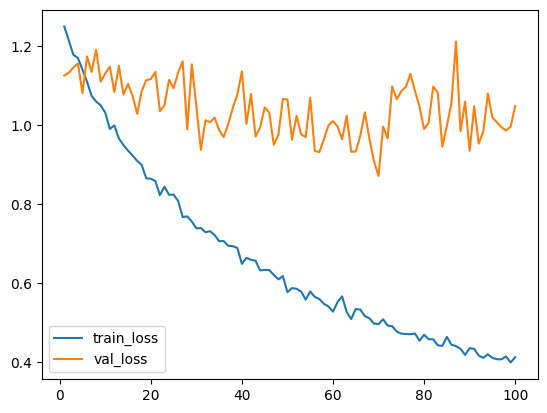

In [19]:
plt.plot(range(1,101),his.history["loss"],label="train_loss")
plt.plot(range(1,101),his.history["val_loss"],label="val_loss")
plt.legend()                               

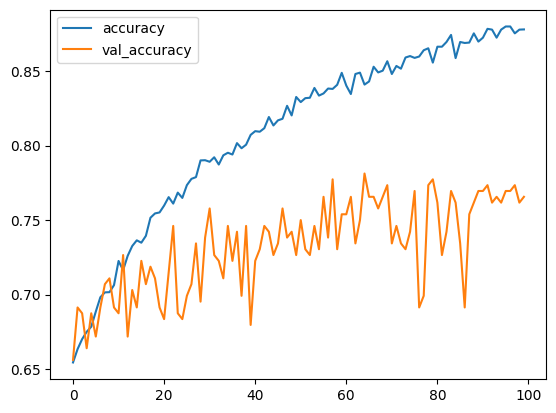

In [20]:
plt.plot(his.history['accuracy'], label='accuracy')
plt.plot(his.history['val_accuracy'], label='val_accuracy')
plt.legend(loc="upper left")
plt.show()

In [21]:
prediction = fmodel.predict(testing)

predicted= np.argmax(prediction,axis=1)

9/9 [==============================] - 2s 261ms/step


In [23]:
from sklearn.metrics import accuracy_score

In [24]:
print('accuracy:',accuracy_score(testing.labels,predicted))

accuracy: 0.018867924528301886
